# Описание проекта 

В проекте разработана модель, которая способна определить рыночную стоимость автомобиля на основании данных о технических характеристиках, комплектации и ценах других автомобилей на 2016 год.

В проекте проанализирован ряд ML моделей. Среди них выбрана лучшая по критериям: 

- качество предсказания;
- время обучения модели;
- время предсказания модели.


![](https://autovista24.autovistagroup.com/wp-content/uploads/sites/5/2023/02/GettyImages-1335040295-1024x695.jpg)

# Импорт данных 

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

import catboost as cb

#conda install -c conda-forge lightgbm
import lightgbm as lgb

# pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report

import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import sys
import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")


In [2]:
cars = pd.read_csv('./autos.csv')

**Описание данных:**

Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:
- Price — цена (евро)

# Разведочный анализ

Общий анализ данных.

In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Определение данных с пропусками.

In [4]:
# Список признаков с пропусками.
features_isna = []
for i in cars.columns:
    if cars[i].isna().sum() > 0:
        features_isna.append(i)
    
print(f'Пропуски наблюдаются в следующих признаках: {features_isna}')

Пропуски наблюдаются в следующих признаках: ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']


In [5]:
# Определение количества пропусков.
isna_count = 0
for i in features_isna:
    isna_count += cars[i].isna().sum()
print(f'Общее количество пропусков: {isna_count}')

# Определение долей пропусков.
for i in features_isna:
    i_ratio = cars[i].isna().sum() / isna_count
    print(f'Доля пропусков в данных {i} составляет: {int(i_ratio.round(2) * 100)} %')

Общее количество пропусков: 181077
Доля пропусков в данных VehicleType составляет: 21 %
Доля пропусков в данных Gearbox составляет: 11 %
Доля пропусков в данных Model составляет: 11 %
Доля пропусков в данных FuelType составляет: 18 %
Доля пропусков в данных Repaired составляет: 39 %


**Вывод:**

В данных о починке автомобиля содержится большее количесто пропусков. Меньше всего пропусков допущено в данных о моделе и типе коробки передач.

## VehicleType

Анализ уникальных значения параметра.

In [6]:
cars['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Заполнение пропусков nan значением 'no_info'.

In [7]:
cars['VehicleType'] = cars['VehicleType'].fillna('no_info')
cars['VehicleType'].unique()

array(['no_info', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

**Пропуски заполнены. Анамалии отсутствуют.**

## Model

Анализ уникальных значения параметра.

In [8]:
cars['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

Т.к. в признаках используется значения 'other' для обозначения неизвестных моделей автотранспорта, то заполним все пропуски nan значением 'other'.

In [9]:
cars['Model'] = cars['Model'].fillna('no_info')

**Пропуски заполнены. Неадекватные значения отсутствуют.**

## Gearbox 

В матрице корреляций 𝜙k параметр Gearbox максимально коррелирует с параметром Model. Заполним пропуски в параметре Gearbox наиболее частыми значениями для каждого класса из Model.

In [10]:
cars['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [11]:
model_unique = cars['Model'].unique()
# Цикл, заполняющий пропуски в данных. 
# Для каждой модели авто определяется наиболее распространенный тип трансмисси, которым заполняются пропуски.
for i in model_unique:
    frequency = cars.loc[cars['Model'] == i].groupby('Gearbox')['Model'].count().reset_index()
    frequency = frequency.sort_values(by='Model', ascending=False).reset_index(drop = True)['Gearbox'][0]
    cars['Gearbox'] = cars['Gearbox'].fillna(frequency)

In [12]:
cars['Gearbox'].unique()

array(['manual', 'auto'], dtype=object)

**Пропуски заполнены. Неадекватные значения отсутствют.**

## FuelType

В матрице корреляций 𝜙k параметр FuelType максимально коррелирует с параметром Model.Заполнение пропусков в параметре FuelType осуществляется наиболее частыми значениями для каждого класса из Model.

Также классы 'petrol' и 'gasoline' объеденены в один ('petrol') т.к. имеют один смысл.

In [13]:
cars['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [14]:
# Объединение классов  'petrol' и 'gasoline'.
cars['FuelType'] = cars['FuelType'].replace('gasoline', 'petrol')

In [15]:
# Цикл, заполняющий пропуски в данных. 
# Для каждой модели авто определяется наиболее распространенный тип топлива, которым заполняются пропуски.
for i in model_unique:
    frequency = cars.loc[cars['Model'] == i].groupby('FuelType')['Model'].count().reset_index()
    frequency = frequency.sort_values(by='Model', ascending=False).reset_index(drop = True)['FuelType'][0]
    cars['FuelType'] = cars['FuelType'].fillna(frequency)

In [16]:
cars['FuelType'].unique()

array(['petrol', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

**Пропуски заполнены.**

## Repaired

Параметр Repaired не зависит ни от каких параметров в исходном датафрейме. Правильным решение будет заполнить все пропуски датафрейма отметкой 'no_info'.

In [17]:
cars['Repaired']

0         NaN
1         yes
2         NaN
3          no
4          no
         ... 
354364    yes
354365    NaN
354366     no
354367     no
354368    NaN
Name: Repaired, Length: 354369, dtype: object

In [18]:
cars['Repaired'] = cars['Repaired'].fillna('no_info')

## DateCrawled / LastSeen / DateCreated

Замена формата даты и времени.

In [19]:
cars['DateCrawled'] = pd.to_datetime(cars['DateCrawled'],format='%Y.%m.%d %H:%M:%S').round('D')
cars['LastSeen']=pd.to_datetime(cars['LastSeen'],format='%Y.%m.%d %H:%M:%S').round('D')
cars['DateCreated']=pd.to_datetime(cars['DateCreated'],format='%Y.%m.%d %H:%M:%S').round('D')
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        354369 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            354369 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              354369 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           354369 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           354369 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

## RegistrationYear

In [20]:
cars['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

<AxesSubplot:xlabel='Price', ylabel='RegistrationYear'>

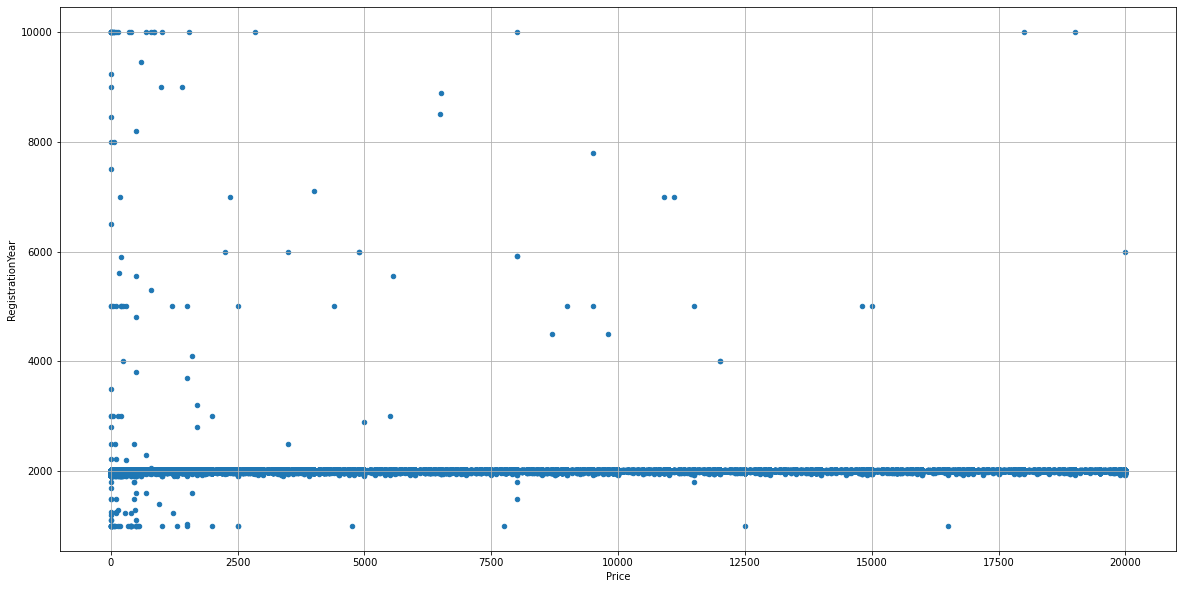

In [21]:
#График распределения стоимостей в зависимости от года.
cars.plot(kind = 'scatter', y = 'RegistrationYear', x = 'Price', grid = True, legend=True, figsize = (20,10))

Обучающий датасет выгружен на момент 2016 года. Соответственно верхняя граница данного параметра равна 2016.
Для определения нижней границы строится график распределения стоимости в зависимости от года.

In [22]:
#Замена годов регистрации превывшающих 2016 год на медианное значение.
cars.loc[cars['RegistrationYear'] > 2016, 'RegistrationYear'] = cars['RegistrationYear'].mean()

Нижний порого определяется в несколько приближений. 
1 шаг. Замена данных выходящих за 1 процентиль на медианное значение.

In [23]:
# Определение процентилей.
cars['RegistrationYear'].describe()

count    354369.000000
mean       2002.401241
std          13.663192
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

In [24]:
# Замена годов регистрации ниже 1999 года на медианное значение.
cars.loc[cars['RegistrationYear'] < 1999, 'RegistrationYear'] = cars['RegistrationYear'].mean()

In [25]:
cars['RegistrationYear']=cars['RegistrationYear'].astype(int)
cars['RegistrationYear'].unique()

array([2002, 2011, 2004, 2001, 2008, 2014, 2005, 2016, 2007, 2009, 2003,
       2006, 1999, 2012, 2010, 2000, 2013, 2015])

**Даты регистрации приведены к адекватному вивду**

## RegistrationMonth

In [26]:
cars['RegistrationMonth'].astype('int').unique()
cars['RegistrationMonth'] = cars['RegistrationMonth'].astype(int)

Удаление некорректных значений.

In [27]:
cars.loc[cars['RegistrationMonth']>12, 'RegistrationMonth'] = int(cars['RegistrationMonth'].mean())
cars.loc[cars['RegistrationMonth']<1, 'RegistrationMonth'] = int(cars['RegistrationMonth'].mean())
cars['RegistrationMonth'] = cars['RegistrationMonth'].astype(int)
cars['RegistrationMonth'].unique()

array([ 5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

## Power 

Оценка распределения параметра Power.

Text(0, 0.5, 'Кол-во авто')

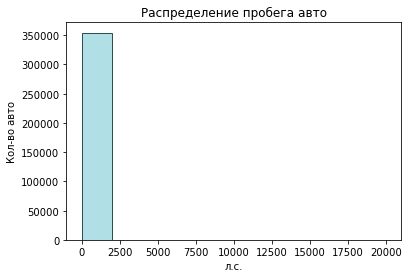

In [28]:
plt.hist(cars['Power'], 
         bins=10,
         color = 'powderblue',
         edgecolor='darkslategray',
         linewidth = 1,
)
plt.title("Распределение пробега авто")
plt.xlabel("л.с.")
plt.ylabel("Кол-во авто")

Свыше 700 л.с. могут находится либо мощыне транспортные средствва не относящиеся к легковвым авто либо спорткары. Данные значения искажают данные. Поэтому в последующей модели не учитываются.

In [29]:
#Определение кол-ва значений в 4 квартиле.
cars[cars['Power'] > 700].count()

DateCrawled          354
Price                354
VehicleType          354
RegistrationYear     354
Gearbox              354
Power                354
Model                354
Kilometer            354
RegistrationMonth    354
FuelType             354
Brand                354
Repaired             354
DateCreated          354
NumberOfPictures     354
PostalCode           354
LastSeen             354
dtype: int64

In [30]:
cars[cars['Power'] > 700].count()

DateCrawled          354
Price                354
VehicleType          354
RegistrationYear     354
Gearbox              354
Power                354
Model                354
Kilometer            354
RegistrationMonth    354
FuelType             354
Brand                354
Repaired             354
DateCreated          354
NumberOfPictures     354
PostalCode           354
LastSeen             354
dtype: int64

Удалим строки, где значение л.с. превышает 700.

In [31]:
cars = cars[cars['Power'] <= 700] 

## NumberOfPictures

In [32]:
cars['NumberOfPictures'].value_counts()

0    354015
Name: NumberOfPictures, dtype: int64

**Параметр имеет неадекватные значения и может быть удален**

In [33]:
cars = cars.drop('NumberOfPictures', axis = 1)

## Kilometer

In [34]:
#Анализ значений параметра.
cars['Kilometer'].unique()

array([150000, 125000,  90000,  40000,  30000,  70000,   5000, 100000,
        60000,  20000,  80000,  50000,  10000])

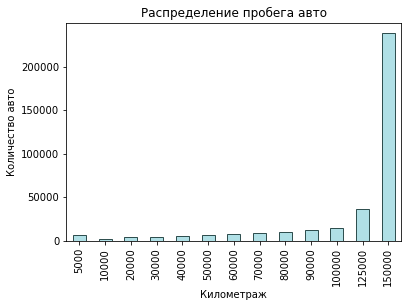

In [35]:
# Подготовка данныx для столбчатой диаграммы
kilometer_values = cars.groupby('Kilometer')['Price'].count()
kilometer_values = cars.groupby('Kilometer')['Price'].count()
kilometer_values.plot(kind='bar', color='powderblue', edgecolor='darkslategray')
plt.title("Распределение пробега авто")
plt.xlabel("Километраж")
plt.ylabel("Количество авто")
plt.show()

**Вывод:**
- Пробег авто не имеет очевидных выбросов.
- Параметр по смыслу похож на категориальный и показывает в каком диапазоне находится пробег машины.

## PostalCode

In [36]:
cars['PostalCode'].describe()

count    354015.000000
mean      50514.035504
std       25783.437938
min        1067.000000
25%       30165.000000
50%       49413.000000
75%       71083.000000
max       99998.000000
Name: PostalCode, dtype: float64

Text(0, 0.5, 'Кол-во авто')

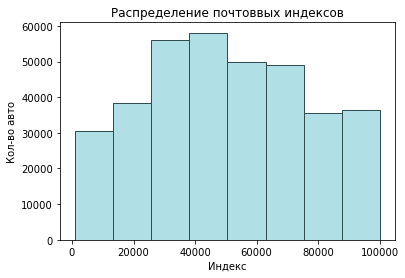

In [37]:
plt.hist(cars['PostalCode'], 
         bins=8,
         color = 'powderblue',
         edgecolor='darkslategray',
         linewidth = 1,
)
plt.title("Распределение почтоввых индексов")
plt.xlabel("Индекс")
plt.ylabel("Кол-во авто")

**Аномалии в данных отсутствуют.**

## Price

Анализ распределения цен стоимостей авто.

Text(0, 0.5, 'Кол-во авто')

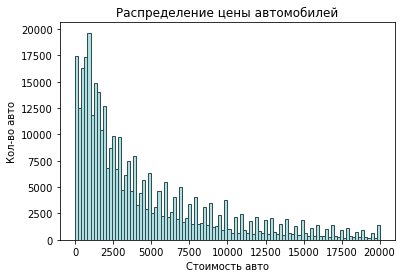

In [38]:
plt.hist(cars['Price'], 
         bins=100,
         color = 'powderblue',
         edgecolor='darkslategray',
         linewidth = 1,
)
plt.title("Распределение цены автомобилей")
plt.xlabel("Стоимость авто")
plt.ylabel("Кол-во авто")



Из графика видно, что очень большое количество авто имеют нулевую стоимость. 
Это выглядит неправдоподобно. Поэтому для точной работы модели устанавливается нижняя граница стоимости авто в  100 евро. Строки, в которых цена ниже данной границы - удаляются.

In [39]:
# Определение процентилей.
cars['Price'].describe()

count    354015.000000
mean       4418.144242
std        4514.917529
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

Удаление данных, в которых цена авто меньше, чем 100 

In [40]:
cars = cars[cars['Price'] > 100]

Text(0, 0.5, 'Кол-во авто')

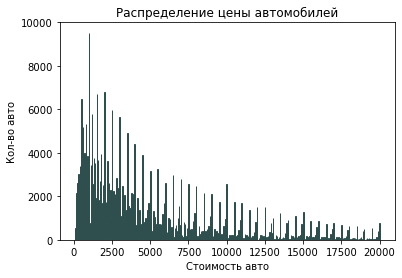

In [41]:
plt.hist(cars['Price'], 
         bins=500,
         color = 'powderblue',
         edgecolor='darkslategray',
         linewidth = 1,
)
plt.title("Распределение цены автомобилей")
plt.xlabel("Стоимость авто")
plt.ylabel("Кол-во авто")



## Анализ на наличие дубликатов

In [42]:
print(f'Количество дубликатов в датасете: {cars.duplicated().sum()}')

Количество дубликатов в датасете: 6750


In [43]:
cars.drop_duplicates(inplace=True)
cars = cars.reset_index(drop=True)
print('Количество дубликатов после удаления:', cars.duplicated().sum())


Количество дубликатов после удаления: 0


## Проверка на мультиколлинеарность

Анализ взаимосвязи признаков между собой и с целевым признаком. 

In [44]:
%%time
#Матрица корреляции / Correlation matrix
phik_cars = cars.phik_matrix()
phik_cars


interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode']
CPU times: user 3.49 s, sys: 729 ms, total: 4.22 s
Wall time: 7.8 s


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
DateCrawled,1.000000,0.034191,0.036951,0.020382,0.007918,0.018688,0.060169,0.023623,0.024025,0.010394,0.022588,0.034204,0.994462,0.075746,0.827596
Price,0.034191,1.000000,0.277576,0.680910,0.332300,0.492895,0.572985,0.313285,0.146217,0.045511,0.362022,0.348547,0.058688,0.092667,0.168217
VehicleType,0.036951,0.277576,1.000000,0.421467,0.216247,0.417580,0.892843,0.243335,0.173317,0.086200,0.581053,0.423295,0.050390,0.067826,0.079665
RegistrationYear,0.020382,0.680910,0.421467,1.000000,0.121963,0.263924,0.552247,0.471109,0.156067,0.059251,0.273656,0.278413,0.043000,0.077949,0.101311
Gearbox,0.007918,0.332300,0.216247,0.121963,1.000000,0.548750,0.609835,0.016891,0.068173,0.102716,0.498809,0.035187,0.019773,0.089914,0.037686
Power,0.018688,0.492895,0.417580,0.263924,0.548750,1.000000,0.721314,0.065024,0.143750,0.083203,0.525576,0.242587,0.027012,0.096263,0.075913
Model,0.060169,0.572985,0.892843,0.552247,0.609835,0.721314,1.000000,0.436471,0.171448,0.338062,0.997827,0.300179,0.251594,0.212914,0.101742
Kilometer,0.023623,0.313285,0.243335,0.471109,0.016891,0.065024,0.436471,1.000000,0.044373,0.078788,0.275164,0.225449,0.054143,0.037544,0.082657
RegistrationMonth,0.024025,0.146217,0.173317,0.156067,0.068173,0.143750,0.171448,0.044373,1.000000,0.014082,0.088080,0.261722,0.036366,0.042501,0.022862
FuelType,0.010394,0.045511,0.086200,0.059251,0.102716,0.083203,0.338062,0.078788,0.014082,1.000000,0.232860,0.036884,0.000000,0.045527,0.013592


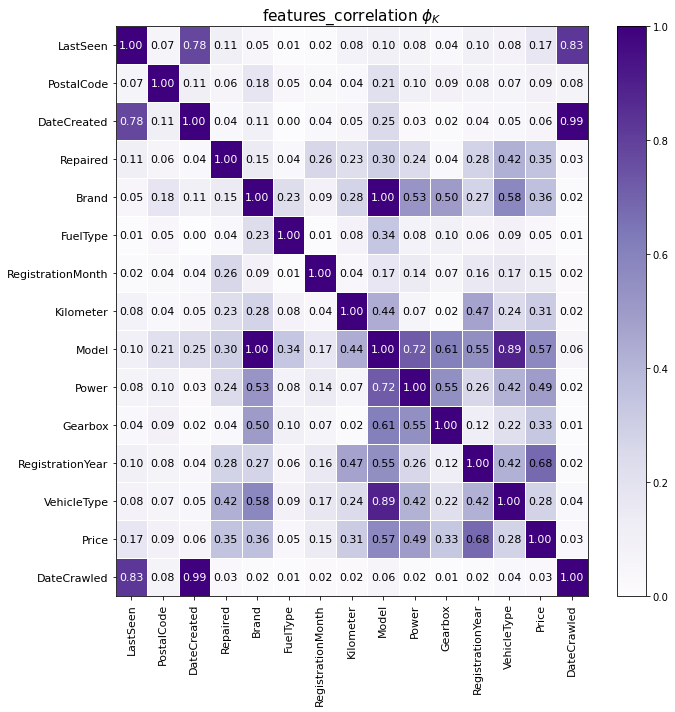

In [45]:
#Визуализация матрицы 𝜙k / 𝜙k matrix visualisation

plot_correlation_matrix(phik_cars.values, 
                        x_labels=phik_cars.columns, 
                        y_labels=phik_cars.index, 
                        vmin=0, vmax=1, color_map="Purples", 
                        title=r"features_correlation $\phi_K$", 
                        fontsize_factor=1.1, 
                        figsize=(10, 10))
plt.tight_layout()

In [46]:
#Список признаков, не коррелирующих с целевым:

features_non_corr = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen']

#Features remooving
cars = cars.drop(features_non_corr, axis=1)

In [47]:
print(f'Количество дубликатов в датасете: {cars.duplicated().sum()}')

Количество дубликатов в датасете: 48186


In [48]:
#Duplicates deleting
cars.drop_duplicates(inplace=True)
cars = cars.reset_index(drop=True)
print('Количество дубликатов после удаления:', cars.duplicated().sum())

Количество дубликатов после удаления: 0


## Вывод:

В рамках разведочного анализа вывполнены следующие действия:
- Обнаружены вывбросы и аномалии в значениях. Произведена их очистка.
- Заполнены пропуски в данных.
- Удалены признаки не коррелирующие с целевым.


## Вывод

На этапе заверешения предобработки данных были выполнены следующие шаги:
1) Пропуски заполнены;

2) Форматы данных исправлены;

3) Выбросы устранены;

4) Корреляция признаков проанализирована.


# Подбор  ML модели

## Подготовка выборок.

Определение целевого признака и набора фичей.

In [49]:
X = cars.drop('Price', axis=1)
y = cars['Price']

Разбиение на тренировочную, валидационную, и тестовую выборки.

In [50]:
# Получение тренировочной выборки.
X_train, X_valid_test, y_train, y_valid_test = train_test_split(
    X, y, test_size = 0.4, random_state = 12345)

# Разбиение на валидационную и тестовую выборки.
X_test, X_valid, y_test, y_valid = train_test_split(
    X_valid_test, y_valid_test, test_size = 0.2, random_state = 12345)

Определение категориальных признаков.

In [51]:
cat_features = list(X.select_dtypes(include = 'object').columns)
cat_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [52]:
#Creation of a DataFrame to compare all model changes and control all modifications.
data = {'ML type':[],
        'change description':[],
        'RMSE':[],
        'learning_time':[],
        'prediction_time':[]
       }
experiment = pd.DataFrame(data)

## LightGBM

LightGBM умеет работать с категориальными переменными. Это значит, что нет необходимости применять кодирование. Для корректной работы модели необходимо привести категориальные признаки к типу category. 

In [53]:
gbm_features = list(X_train.columns)
gbm_features

['VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Kilometer',
 'FuelType',
 'Brand',
 'Repaired']

In [54]:
X_train_gbm = X_train.copy()

Приведение всех категориальных признаков к типу category.

In [55]:
for cat in cat_features:
    X_train_gbm[cat] = X_train_gbm[cat].astype('category')
X_train_gbm.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170859 entries, 219660 to 217570
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       170859 non-null  category
 1   RegistrationYear  170859 non-null  int64   
 2   Gearbox           170859 non-null  category
 3   Power             170859 non-null  int64   
 4   Model             170859 non-null  category
 5   Kilometer         170859 non-null  int64   
 6   FuelType          170859 non-null  category
 7   Brand             170859 non-null  category
 8   Repaired          170859 non-null  category
dtypes: category(6), int64(3)
memory usage: 6.4 MB


Счетчик времени работы модели  LightGBM

In [56]:
LightGBM_time_train = 0
LightGBM_time_predict = 0

**Подбор гиперпараметров GreedSearch.**

In [57]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7]
}

In [58]:
# Инициализация модели
lgb_model = lgb.LGBMRegressor()

In [62]:

# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=lgb_model, 
                           param_grid=param_grid, 
                           cv=3, 
                           scoring='neg_mean_squared_error', 
                           verbose=0
                          )

# Обучение на тренировочных данных
grid_search.fit(X_train_gbm, y_train)

# Вывод лучших параметров
print("Лучшие параметры:", grid_search.best_params_)

# Лучшие гиперпараметры
best_lgb_parameters = grid_search.best_params_

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

**Обучение модели.**

In [63]:
%%time
start_gbm_train = time.time()
# формирование сета данных для модели

train_data = lgb.Dataset ( X_train_gbm , label = y_train , feature_name = gbm_features ,
                           categorical_feature = cat_features
                           )

# обучение модели

num_round = 10000
lgb_model = lgb.train(best_lgb_parameters, train_data, num_round)
end_gbm_train = time.time()

#Cumulative ML work time
LightGBM_time_train += end_gbm_train - start_gbm_train

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 583
[LightGBM] [Info] Number of data points in the train set: 170859, number of used features: 9
[LightGBM] [Info] Start training from score 4785.598359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

In [64]:
%%time

X_test_gbm = X_valid.copy()
start_gbm_predict = time.time()

for cat in cat_features:
    X_test_gbm[cat] = X_test_gbm[cat].astype('category')



ypred = lgb_model.predict(X_test_gbm)
gbm_rmse = mean_squared_error(y_valid, ypred) ** 0.5

end_gbm_predict = time.time()
LightGBM_time_predict += end_gbm_predict - start_gbm_predict

print(f'RMSE модели на базе библиотеки LGBM {gbm_rmse}')

RMSE модели на базе библиотеки LGBM 1742.825798758418
CPU times: user 2.21 s, sys: 12.9 ms, total: 2.23 s
Wall time: 353 ms


Добавление результатов в сводную таблицу.

In [65]:
new_result = {'ML type': 'LightGBM',
        'change description':'LightGBM comparison',
        'RMSE':gbm_rmse.round(2),
        'learning_time':LightGBM_time_train,
        'prediction_time':LightGBM_time_predict
       }

In [66]:
experiment = experiment.append(new_result, ignore_index=True)
experiment

,ML type,change description,RMSE,learning_time,prediction_time
0,LightGBM,LightGBM comparison,1742.83,5.203573,0.352361


**Вывод:**

 - Из сводной таблицы видно, что модель LightGBM ускоряет обучение модели почти в 8 раз по сравнению с базовой моделью. Скорость предсказания модели увеличивается незначительно, а метрика RMSE увеличивается приблизительно на 100.

## CatBoost

**Подбор гиперпараметров.**

In [67]:
param_grid = {
    'iterations' : range(100, 1000, 100),
    'depth' : range(1, 10, 2),
    'learning_rate': [0.01, 0.1, 0.2]
}

In [68]:
# Инициализация модели
cbr_model = cb.CatBoostRegressor()

In [69]:
# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=cbr_model, 
                           param_grid=param_grid, 
                           cv=3, 
                           scoring='neg_mean_squared_error', 
                           verbose=1
                          )

In [70]:
# Обучение на тренировочных данных
grid_search.fit(X_train, y_train, cat_features = cat_features, verbose=0)

Fitting 3 folds for each of 135 candidates, totalling 405 fits


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fc88e6b8130>,
             param_grid={'depth': range(1, 10, 2),
                         'iterations': range(100, 1000, 100),
                         'learning_rate': [0.01, 0.1, 0.2]},
             scoring='neg_mean_squared_error', verbose=1)

In [71]:
# Вывод лучших параметров
print("Лучшие параметры:", grid_search.best_params_)

# Лучшие гиперпараметры
best_cbr_parameters = grid_search.best_params_

Лучшие параметры: {'depth': 9, 'iterations': 900, 'learning_rate': 0.1}


**Обучение модели.**

In [72]:
#Счетчи к времени работы модели в секундах.
CBR_time_fit = 0
CBR_time_predict = 0

In [73]:
%%time

start_cbr_fit = time.time()

cbr = cb.CatBoostRegressor(depth = 9, 
                           iterations = 900,
                           learning_rate = 0.1,
                            boosting_type='Ordered',
                            loss_function='RMSE',
                            eval_metric = 'R2'
                          )
cbr.fit(X_train,y_train, 
        cat_features = cat_features, 
        verbose=False,
        plot=True)

end_cbr_fit = time.time()
CBR_time_fit = end_cbr_fit - start_cbr_fit


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 14min 41s, sys: 11.3 s, total: 14min 53s
Wall time: 2min 30s


In [74]:
%%time
start_cbr_predict = time.time()
# Определение метрики RMSE
cbr.predict
rmse = np.sqrt(mean_squared_error(y_valid, cbr.predict(X_valid)))

end_cbr_predict = time.time()
CBR_time_predict = end_cbr_predict - start_cbr_predict
print(f'Метрика RMSE = {rmse.round(2)}')
print()
print('________________________________')
print()

Метрика RMSE = 1787.66

________________________________

CPU times: user 514 ms, sys: 16.8 ms, total: 531 ms
Wall time: 126 ms


In [75]:
new_result = {'ML type': 'CatBoost',
        'change description':'CatBoost comparison',
        'RMSE':rmse.round(2),
        'learning_time':CBR_time_fit,
        'prediction_time':CBR_time_predict
       }

In [76]:
experiment = experiment.append(new_result, ignore_index=True)
experiment

,ML type,change description,RMSE,learning_time,prediction_time
0,LightGBM,LightGBM comparison,1742.83,5.203573,0.352361
1,CatBoost,CatBoost comparison,1787.66,150.685185,0.125602


**Вывод:**

 - Из сводной таблицы видно, что модель CatBoost с подобранными гиперпараметрами получает метрику RMSE незначительно хуже чем LightGBM, однако время работы больше почти в 60 раз.

## LinearRegression and SVR ensemble

Обучение ансамбля моделей на базе линейной регрессии и опорных векторов. 
- Кодирование категориальных признаков методом OHE;
- Стандартизация количественных признаков.

In [77]:
num_features = list(set(X_train.columns) - set(cat_features))
num_features

['RegistrationYear', 'Kilometer', 'Power']

In [78]:
#Счетчик времени, затраченного на модель.
ensemble_time_fit = 0
ensemble_time_predict = 0

Построение пайплайна.

In [79]:
#Стандартизация признаков.
numeric_transformer = StandardScaler()
#Зашифровка катигориальных признаков методом OHE.
categorical_transformer = OneHotEncoder() #np.nan

preprocessor = ColumnTransformer (
    transformers = [
        ('num' , numeric_transformer , num_features) ,
        ('cat' , categorical_transformer , cat_features) ]
    )

In [80]:
%%time
ensemble_start = time.time()

X_train_reg = preprocessor.fit_transform(X_train)
X_valid_reg  = preprocessor.transform(X_valid)

ensemble_end = time.time()
ensemble_time = ensemble_end - ensemble_start


CPU times: user 376 ms, sys: 53.9 ms, total: 430 ms
Wall time: 433 ms


In [81]:
#Feature value analysis,
X_train_reg.shape, X_valid_reg.shape

((170859, 314), (22782, 314))

In [82]:
X_train

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
219660,wagon,2002,manual,107,3_reihe,150000,petrol,peugeot,no
252540,sedan,2011,auto,190,a4,150000,petrol,audi,no
138622,coupe,1999,manual,150,3er,150000,petrol,bmw,no
9310,convertible,2001,auto,203,other,150000,petrol,chrysler,no_info
3689,sedan,1999,auto,102,e_klasse,40000,petrol,mercedes_benz,no
...,...,...,...,...,...,...,...,...,...
158838,bus,2001,manual,131,other,150000,petrol,volkswagen,no
47873,sedan,2001,manual,98,3_reihe,150000,petrol,mazda,no
86398,coupe,2000,manual,133,other,150000,petrol,honda,no
77285,sedan,2002,auto,109,no_info,150000,petrol,peugeot,no


**Подбор гиперпараметров.**

In [83]:
param_grid = {
    'C': [0.1, 1.0, 10.0],  # Регуляризационный параметр C
    'epsilon': [0.1, 0.5, 1.0],  # Параметр epsilon
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

In [84]:
# Экземпляр модели LinearSVR
svr_reg = LinearSVR(random_state=42)

In [85]:
# Инициализация объекта GridSearchCV для поиска лучших параметров
grid_search_svr = GridSearchCV(estimator=svr_reg, 
                               param_grid=param_grid, 
                               cv=3, 
                               scoring='neg_mean_squared_error', 
                               verbose=1)

# Обучите модель на тренировочных данных
grid_search_svr.fit(X_train_reg, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=LinearSVR(random_state=42),
             param_grid={'C': [0.1, 1.0, 10.0], 'epsilon': [0.1, 0.5, 1.0],
                         'loss': ['epsilon_insensitive',
                                  'squared_epsilon_insensitive']},
             scoring='neg_mean_squared_error', verbose=1)

In [86]:
# Выведиение лучших результатов
print("Лучшие параметры для LinearSVR:", grid_search_svr.best_params_)

# Лучшие гиперпараметры
best_svr_parameters = grid_search.best_params_

Лучшие параметры для LinearSVR: {'C': 1.0, 'epsilon': 0.1, 'loss': 'squared_epsilon_insensitive'}


**Обучение модели.**

In [87]:
%%time
voting_start_fit = time.time()

lin_reg = LinearRegression()

svr_reg = LinearSVR(epsilon = 0.1, random_state=42)
voting_reg = VotingRegressor(
    estimators=[('lr', lin_reg), ('svr', svr_reg)])

voting_reg.fit(X_train_reg, y_train)

voting_end_fit = time.time()
ensemble_time_fit += voting_end_fit - voting_start_fit

CPU times: user 11 s, sys: 123 ms, total: 11.2 s
Wall time: 2.9 s


In [88]:
%%time
voting_start_predict = time.time()

vot_pred = voting_reg.predict(X_valid_reg)
vot_rmse = mean_squared_error(y_valid, vot_pred) ** 0.5

voting_end_predict = time.time()
ensemble_time_predict += voting_end_predict - voting_start_predict

print(f'RMSE модели на базе библиотеки Sklearn - ансамбль {vot_rmse}')

RMSE модели на базе библиотеки Sklearn - ансамбль 2722.0280030720915
CPU times: user 3.66 ms, sys: 3.49 ms, total: 7.15 ms
Wall time: 5.31 ms


In [89]:

new_result = {'ML type': 'LinearRegression and SVR ensemble',
        'change description':'LinearRegression and SVR ensemble comparison',
        'RMSE':vot_rmse.round(2),
        'learning_time':ensemble_time_fit,
        'prediction_time':ensemble_time_predict
       }

In [90]:
experiment = experiment.append(new_result, ignore_index=True)
experiment

,ML type,change description,RMSE,learning_time,prediction_time
0,LightGBM,LightGBM comparison,1742.83,5.203573,0.352361
1,CatBoost,CatBoost comparison,1787.66,150.685185,0.125602
2,LinearRegression and SVR ensemble,LinearRegression and SVR ensemble comparison,2722.03,2.904679,0.005138


**Вывод:**

 - Из сводной таблицы видно, что ансамбль моделей LinearRegression и SVR с подобранными гиперпараметрами получает метрику RMSE хуже чем LightGBM в полтора раза. Однако время обучения равно 2 с, а время предсказания меньше на два порядка.

# Проверка результатов на тестовой выборке.

Исходя из метрики RMSE времени обучения модели и времени, за которое она делает предсказание, определено, что лучшей моделю для определения стоимости автомобиля является LightGBM.

Для проверки работоспособности модели производится определение метрики RMSE и ввремени работы модели на тестовой моделе.

In [91]:
LightGBM_time_train = 0
LightGBM_time_predict = 0

In [92]:
%%time
#Обучение модели
start_gbm_train = time.time()
# формирование сета данных для модели

train_data = lgb.Dataset ( X_train_gbm , label = y_train , feature_name = gbm_features ,
                           categorical_feature = cat_features
                           )

# обучение модели

num_round = 10000
lgb_model = lgb.train(best_lgb_parameters, train_data, num_round)
end_gbm_train = time.time()

#Cumulative ML work time
LightGBM_time_train += end_gbm_train - start_gbm_train

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 583
[LightGBM] [Info] Number of data points in the train set: 170859, number of used features: 9
[LightGBM] [Info] Start training from score 4785.598359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

In [93]:
%%time
#Предсказание на тестовой вывборке.
X_test_gbm = X_test.copy()
start_gbm_predict = time.time()

for cat in cat_features:
    X_test_gbm[cat] = X_test_gbm[cat].astype('category')



ypred = lgb_model.predict(X_test_gbm)
gbm_rmse = mean_squared_error(y_test, ypred) ** 0.5

end_gbm_predict = time.time()
LightGBM_time_predict += end_gbm_predict - start_gbm_predict

print(f'RMSE модели на базе библиотеки LGBM {gbm_rmse}')

RMSE модели на базе библиотеки LGBM 1753.4597195361134
CPU times: user 8.78 s, sys: 65.1 ms, total: 8.85 s
Wall time: 1.36 s


In [94]:
new_result = {'ML type': 'LightGBM',
        'change description':'LightGBM comparison test sample',
        'RMSE':gbm_rmse.round(2),
        'learning_time':LightGBM_time_train,
        'prediction_time':LightGBM_time_predict
       }

In [95]:
experiment = experiment.append(new_result, ignore_index=True)
experiment

,ML type,change description,RMSE,learning_time,prediction_time
0,LightGBM,LightGBM comparison,1742.83,5.203573,0.352361
1,CatBoost,CatBoost comparison,1787.66,150.685185,0.125602
2,LinearRegression and SVR ensemble,LinearRegression and SVR ensemble comparison,2722.03,2.904679,0.005138
3,LightGBM,LightGBM comparison test sample,1753.46,4.634211,1.341656


**Вывод:**
Результаты на тестоввой выборке сопоставимы с результатами на валидационной  части метрики Однако время обучения и предсазания значительно уеличены. 

# Вывод.

В рамках проекта была разработана система предсказания стоимости автомобиля, позволяющая определять цену на основании технических параметровв авто.

Преокт состоит из следующих этапов:

- Предобработка данных;
- Проверка важности признаков и подбор гиперпараметров;
- Разработка модели предсказания стоимости LightGBM;
- Разработка модели предсказания стоимости CatBoost;
- Разработка ансамбля моделей предсказания стоимости LinearRegression и SVR.


**Критерии определения наилучшей модели:**
- качество предсказания;
- время обучения модели;
- время предсказания модели.

**Определение модели определения стоимости авто.**
Для оценки наилучшей рекомендательной системы впроекте представлена сводная таблица с результатами основных вех исследования. Из трех рассмотренных ML моделей заметно выделяется LightGBM. Данная модель является лучше всех аналогов и по времени работы и по метрике RMSE.

**Параметры работы модели LightGBM.**
- RMSE = 1749.27;
- Время обучения  = 5 c.
- Время предсказания = 1.4 с.

**Описание гиперпараметров модели LightGBM.**
- learning_rate - скорость обучения модели.
- n_estimators - количество итераций градиентного бустинга.
- objective - целевая функция RMSE(целевая метрика).

**В проекте применены следующие инструменты:**
- LightGBM; 
- CatBoost;
- LinearRegression и SVR ensemble;
- Pandas;
- Numpy.

